In [1]:
from pathlib import Path
import tflite
import tvm
from tvm import relay, transform
from tvm import te
import matplotlib.pyplot as plt
import imageio
import cv2
import numpy as np

In [2]:
model_path = Path.cwd().parent / 'models' / 'face_detection_short_range.tflite'
model_path.exists()

True

In [3]:
with open(model_path, 'rb') as f:
    tflite_model_buf = f.read()
    tflite_model = tflite.Model.GetRootAsModel(tflite_model_buf, 0)
    input_tensor = "input"
    input_shape  = (1, 128, 128, 3)
    input_dtype  = "float32"
    
    mod, params = relay.frontend.from_tflite(
        tflite_model, 
        shape_dict = {input_tensor: input_shape},
        dtype_dict = {input_tensor: input_dtype}
    )
    target = "llvm"
    with transform.PassContext(opt_level=3):
        lib=relay.build(mod, target, params=params)

conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.
depthwise_conv2d NHWC layout is not optimized for x86 with a

In [4]:
video_path = Path.cwd().parent / "build" / "demo1.mp4"
video_path.exists()

True

In [6]:
reader = imageio.get_reader(str(video_path))

In [7]:
image_data = None
for frame in reader:
    image_data = cv2.resize(frame, (128, 128))
    image_data = image_data * 1.0 / 255.0
    image_data = image_data.astype(np.float32)
    break
image_data.shape, image_data.dtype

((128, 128, 3), dtype('float32'))

In [8]:
image_data = image_data[np.newaxis, :]
image_data.shape

(1, 128, 128, 3)

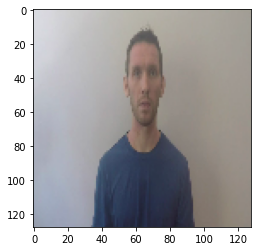

In [9]:
plt.imshow(np.squeeze(image_data))
plt.show()

In [10]:
import tvm
from tvm import te
from tvm.contrib import graph_executor as runtime

# Create a runtime executor module
module = runtime.GraphModule(lib["default"](tvm.cpu()))

# Feed input data
module.set_input(input_tensor, tvm.nd.array(image_data))

# Run
module.run()

In [11]:
output_1 = module.get_output(0).numpy()
output_2 = module.get_output(1).numpy()

In [12]:
output_1.shape

(1, 896, 16)

In [13]:
output_2.shape

(1, 896, 1)

In [14]:
scores = np.squeeze(output_2)
max_score_index = np.argmax(scores)
max_score = scores[max_score_index]
max_score

1.5855491

In [15]:
boxes = np.squeeze(output_1)

In [21]:
boxes.shape, boxes.dtype

((896, 16), dtype('float32'))

In [22]:
boxes[0]

array([ 0.12165964, -0.73016846, 27.367645  , 27.367355  , -2.6123471 ,
       -5.437415  ,  2.4174035 , -5.938799  , -0.44377953, -1.7667279 ,
       -1.6093922 ,  3.4959435 , -8.234564  , -2.3835871 ,  6.875955  ,
       -2.5142145 ], dtype=float32)

In [20]:
scores.shape

(896,)

In [18]:
cv2.dnn.NMSBoxes(boxes, scores, 0.3, 0.1)

error: Conversion error: bboxes, what: OpenCV(4.5.3) /tmp/pip-wheel-pd499c9i/opencv-python_3a15e83eee864e65b7311a199a94e9f1/opencv/modules/core/src/copy.cpp:320: error: (-215:Assertion failed) channels() == CV_MAT_CN(dtype) in function 'copyTo'


In [32]:
best_box = boxes[max_score_index]
best_box * 128

array([ 5.2574963e+02,  8.8113513e+02,  1.2021270e+04,  1.2022848e+04,
       -2.3693877e+03, -2.3095798e+03,  3.3100671e+03, -2.2170645e+03,
        3.1589273e+02,  5.8873367e+00,  2.9502081e+02,  3.0557544e+03,
       -5.0939839e+03, -4.7800259e+02,  6.2647568e+03, -3.5473773e+02],
      dtype=float32)

In [38]:
cv2.dnn.blobFromImage(frame, 1.0/255.0, (128, 128)).shape

(1, 3, 128, 128)